# Run interventions in loop with OpenABM 

In [1]:
import sys
sys.path.insert(0,'./src/')
from pathlib import Path
import log, logging
from importlib import reload
import loop_abm

#logging
output_dir = "./output/"
fold_out = Path(output_dir)
if not fold_out.exists():
    fold_out.mkdir(parents=True)

reload(log)
logger = log.setup_logger()

Log setup complete


In [2]:
BASELINE_PARS_F = "./abm_params/new_default_baseline_parameters.csv"

## Epidemic model

#### set parameters of the openABM foward simulation

In [3]:
N=50000 #Number of individuals
T=100 #Total time of simulations
seed = 1 #random seed
n_seed_infection = 10 #number of patient zero

params_model = {
    "rng_seed" : seed,
    "end_time" : T,
    "n_total"  : N,
    "days_of_interactions" : T,
    "n_seed_infection" : n_seed_infection,
}

## Set testing and quarantine rules

In [4]:
fraction_SM_obs = 0.5 #fraction of Symptomatic Mild tested positive
fraction_SS_obs = 1 #fraction of Symptomatic Severe tested positive
initial_steps = 12 #starting time of intervention
quarantine_HH = True #Households quarantine
test_HH = True #Tests the households when quarantined
adoption_fraction = 1 #app adoption (fraction)
num_test_random = 0 #number of random tests per day
num_test_algo = 200 #number of tests using by the ranker per day

## Choose the rankers algorithms class

In [5]:
from rankers import dotd_rank, tracing_rank, mean_field_rank, sib_rank
import sib


prob_seed = 1/N
prob_sus = 0.55
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1/N
fp_rate = 0.0
fn_rate = 0.0


dotd = dotd_rank.DotdRanker()

tracing = tracing_rank.TracingRanker(
                 tau=5,
                 lamb=0.014
)

MF = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = 1/30,
                lamb = 0.014
                )


sib_ranker = sib_rank.SibRanker(
                 params = sib.Params(
                                 prob_i = sib.Cached(sib.Scaled(sib.PDF(sib.Gamma(k=5.76, mu=0.96)), scale=0.25), T+1),
                                 prob_r = sib.Cached(sib.Gamma(k = 10, mu = 1/1.7452974337097158), T+1),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=7
)


ress = {}


In [6]:
rankers = {
    "random" : dotd,
    "tracing": tracing,
   "MF" : MF,
  "sib_ranker": sib_ranker,

} 

### Set up figure

In [7]:
%matplotlib widget
import matplotlib.pyplot as plt
import plot_utils
import time

plots = plot_utils.plot_style(N, T)
save_path_fig = f"./output/plot_run_N_{N}_SM_{fraction_SM_obs}_test_{num_test_algo}_n_seed_infection_{n_seed_infection}_seed_{seed}.png"
fig, callback = plot_utils.plotgrid(rankers, plots, initial_steps, save_path=save_path_fig)
time.sleep(0.5)
fig.canvas

Canvas(header_visible=False, toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Bac…

In [8]:
from COVID19.model import Model, Parameters, ModelParameterException
def get_openabm_pars(params,
                     output_dir = "./output/",
                     input_parameter_file = BASELINE_PARS_F,
             household_demographics_file = "./abm_params/baseline_household_demographics.csv",
            parameter_line_number = 1,
                            ):

    params_model = Parameters(input_parameter_file,
                              parameter_line_number,
                              output_dir,
                              household_demographics_file)
    for k, val in params.items():
        params_model.set_param(k, val)
    return params_model


In [9]:
params = get_openabm_pars(params_model)

COVID19.model: INFO     Have not passed hospital input file for params, use set_param or set_param_dict// crick todo look into this


In [10]:
RELEV_PARS=[
    "lockdown_random_network_multiplier",
    "lockdown_occupation_multiplier_primary_network",
    "lockdown_occupation_multiplier_secondary_network",
    "lockdown_occupation_multiplier_working_network",
    "lockdown_occupation_multiplier_retired_network",
    "lockdown_occupation_multiplier_elderly_network",
]

", ".join(RELEV_PARS)

{k: params.get_param(k) for k in RELEV_PARS}

{'lockdown_random_network_multiplier': 0.29,
 'lockdown_occupation_multiplier_primary_network': 0.29,
 'lockdown_occupation_multiplier_secondary_network': 0.29,
 'lockdown_occupation_multiplier_working_network': 0.29,
 'lockdown_occupation_multiplier_retired_network': 0.29,
 'lockdown_occupation_multiplier_elderly_network': 0.29}

In [ ]:
import imp 
imp.reload(loop_abm)

for s in rankers:
    data = {"algo":s}
    loop_abm.loop_abm(
        params_model, 
        rankers[s],
        input_parameter_file=BASELINE_PARS_F,
        seed=seed, 
        logger = logging.getLogger(f"iteration.{s}"), 
        data = data, 
        callback = callback,
        initial_steps = initial_steps, 
        num_test_random = num_test_random,
        num_test_algo = num_test_algo,
        fraction_SM_obs = fraction_SM_obs,
        fraction_SS_obs = fraction_SS_obs,
        quarantine_HH = quarantine_HH,
        test_HH = test_HH,
        adoption_fraction = adoption_fraction,
        fp_rate = fp_rate,
        fn_rate = fn_rate,
        name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_SM_obs_{fraction_SM_obs}_seed_{seed}"
    )
    ress[s] = data
    # saves a bit of memory: rankers[s] = {}

COVID19.model: INFO     Have not passed hospital input file for params, use set_param or set_param_dict// crick todo look into this
COVID19.model: INFO     Returning self.c_params into Model object, future updates to parameters not possible
COVID19.model: INFO     Started model creation
COVID19.model: INFO     Successfuly created model
COVID19.model: INFO     Getting param hospital_on
iteration.random: INFO     time:0
iteration.random: INFO     number of unique contacts: 632210
iteration.random: INFO     True  : (S,I,R): (49990.0, 10.0, 0.0)
iteration.random: INFO     AUR_I : 0.390, prec(1% of 50001): 0.00, prec5%: 0.00
iteration.random: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.random: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.random: INFO     ...quarantining 7 guys -> got 2 infected, 8 free as birds (+8)
iteration.random: INFO     time:1
iteration.random: INFO     number of unique contacts: 632418
iteration.random: INFO    

sib.iterate(damp=0):  2/20 1.101e-06/0.001    
sib.iterate(damp=0.5):  0/20 1.685e-08/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49999.1, 0.9, 0.0), seeds: 0.9, ll: -29890.6
iteration.sib_ranker: INFO     True  : (S,I,R): (49990.0, 10.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.390, prec(1% of 50001): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 7 guys -> got 2 infected, 8 free as birds (+8)
iteration.sib_ranker: INFO     time:1
iteration.sib_ranker: INFO     number of unique contacts: 632418


sib.iterate(damp=0):  2/20 6.973e-06/0.001    
sib.iterate(damp=0.5):  0/20 5.279e-07/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49998.3, 1.7, 0.0), seeds: 0.9, ll: -29889.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49988.0, 12.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.457, prec(1% of 49994): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 9 free as birds (+1)
iteration.sib_ranker: INFO     time:2
iteration.sib_ranker: INFO     number of unique contacts: 632824


sib.iterate(damp=0):  2/20 2.310e-05/0.001    
sib.iterate(damp=0.5):  0/20 2.924e-06/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49997.4, 2.6, 0.0), seeds: 0.8, ll: -29893.5
iteration.sib_ranker: INFO     True  : (S,I,R): (49986.0, 14.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.520, prec(1% of 49994): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 11 free as birds (+2)
iteration.sib_ranker: INFO     time:3
iteration.sib_ranker: INFO     number of unique contacts: 632708


sib.iterate(damp=0):  2/20 6.585e-05/0.001    
sib.iterate(damp=0.5):  0/20 1.319e-05/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49996.3, 3.7, 0.0), seeds: 0.7, ll: -29924.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49981.0, 19.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.571, prec(1% of 49994): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 3 guys -> got 1 infected, 15 free as birds (+4)
iteration.sib_ranker: INFO     time:4
iteration.sib_ranker: INFO     number of unique contacts: 632392


sib.iterate(damp=0):  2/20 9.044e-05/0.001    
sib.iterate(damp=0.5):  0/20 2.842e-05/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49995.1, 4.9, 0.0), seeds: 0.6, ll: -30039.0
iteration.sib_ranker: INFO     True  : (S,I,R): (49974.0, 26.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.654, prec(1% of 49991): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (+6)
iteration.sib_ranker: INFO     time:5
iteration.sib_ranker: INFO     number of unique contacts: 633102


sib.iterate(damp=0):  2/20 1.382e-04/0.001    
sib.iterate(damp=0.5):  0/20 5.859e-05/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49993.8, 6.2, 0.0), seeds: 0.5, ll: -30314.4
iteration.sib_ranker: INFO     True  : (S,I,R): (49968.0, 31.0, 1.0)
iteration.sib_ranker: INFO     AUR_I : 0.605, prec(1% of 49991): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 27 free as birds (+6)
iteration.sib_ranker: INFO     time:6
iteration.sib_ranker: INFO     number of unique contacts: 633068


sib.iterate(damp=0):  2/20 1.962e-04/0.001    
sib.iterate(damp=0.5):  0/20 9.598e-05/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49992.4, 7.6, 0.0), seeds: 0.4, ll: -30815.1
iteration.sib_ranker: INFO     True  : (S,I,R): (49961.0, 38.0, 1.0)
iteration.sib_ranker: INFO     AUR_I : 0.599, prec(1% of 49991): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 32 free as birds (+5)
iteration.sib_ranker: INFO     time:7
iteration.sib_ranker: INFO     number of unique contacts: 632176


sib.iterate(damp=0):  2/20 3.692e-04/0.001    
sib.iterate(damp=0.5):  0/20 1.380e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49991.1, 8.9, 0.0), seeds: 0.4, ll: -31555.8
iteration.sib_ranker: INFO     True  : (S,I,R): (49951.0, 47.0, 2.0)
iteration.sib_ranker: INFO     AUR_I : 0.649, prec(1% of 49991): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 42 free as birds (+10)
iteration.sib_ranker: INFO     time:8
iteration.sib_ranker: INFO     number of unique contacts: 631952


sib.iterate(damp=0):  2/20 3.309e-04/0.001        
sib.iterate(damp=0.5):  0/20 1.876e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49989.8, 10.2, 0.0), seeds: 0.3, ll: -32492.3
iteration.sib_ranker: INFO     True  : (S,I,R): (49940.0, 58.0, 2.0)
iteration.sib_ranker: INFO     AUR_I : 0.599, prec(1% of 49991): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 4 guys -> got 1 infected, 52 free as birds (+10)
iteration.sib_ranker: INFO     time:9
iteration.sib_ranker: INFO     number of unique contacts: 632356


sib.iterate(damp=0):  2/20 4.006e-04/0.001        
sib.iterate(damp=0.5):  0/20 2.213e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49988.6, 11.4, 0.0), seeds: 0.2, ll: -33522.2
iteration.sib_ranker: INFO     True  : (S,I,R): (49933.0, 65.0, 2.0)
iteration.sib_ranker: INFO     AUR_I : 0.548, prec(1% of 49987): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 10 guys -> got 5 infected, 54 free as birds (+2)
iteration.sib_ranker: INFO     time:10
iteration.sib_ranker: INFO     number of unique contacts: 633212


sib.iterate(damp=0):  2/20 4.533e-04/0.001    
sib.iterate(damp=0.5):  0/20 3.044e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49987.5, 12.4, 0.1), seeds: 0.2, ll: -34546.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49916.0, 82.0, 2.0)
iteration.sib_ranker: INFO     AUR_I : 0.585, prec(1% of 49977): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 2, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 7 guys -> got 4 infected, 67 free as birds (+13)
iteration.sib_ranker: INFO     time:11
iteration.sib_ranker: INFO     number of unique contacts: 632032


sib.iterate(damp=0):  2/20 4.894e-04/0.001    
sib.iterate(damp=0.5):  0/20 2.724e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49986.7, 13.2, 0.1), seeds: 0.2, ll: -35533.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49895.0, 102.0, 3.0)
iteration.sib_ranker: INFO     AUR_I : 0.580, prec(1% of 49970): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 4 guys -> got 1 infected, 85 free as birds (+18)
iteration.sib_ranker: INFO     
observation-based inference algorithm starts now

iteration.sib_ranker: INFO     time:12
iteration.sib_ranker: INFO     number of unique contacts: 633704


sib.iterate(damp=0):  19/20 1.571e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.915e-01/0.001        


iteration.sib_ranker: INFO     winBP: (S,I,R): (49981.7, 18.2, 0.2), seeds: 0.2, ll: -29966.2
iteration.sib_ranker: INFO     True  : (S,I,R): (49879.0, 116.0, 5.0)
iteration.sib_ranker: INFO     AUR_I : 0.604, prec(1% of 49956): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 6, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 21 guys -> got 12 infected, 87 free as birds (+2)
iteration.sib_ranker: INFO     time:13
iteration.sib_ranker: INFO     number of unique contacts: 633194


sib.iterate(damp=0):  19/20 8.779e-01/0.001    
sib.iterate(damp=0.5):  19/20 4.199e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49924.2, 74.5, 1.3), seeds: 1.4, ll: -31604.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49845.0, 148.0, 7.0)
iteration.sib_ranker: INFO     AUR_I : 0.642, prec(1% of 49933): 0.01, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (196,4,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 12 guys -> got 4 infected, 112 free as birds (+25)
iteration.sib_ranker: INFO     time:14
iteration.sib_ranker: INFO     number of unique contacts: 631686


sib.iterate(damp=0):  19/20 8.224e-01/0.001    
sib.iterate(damp=0.5):  19/20 3.413e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49933.4, 65.5, 1.2), seeds: 0.8, ll: -30407.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49819.0, 171.0, 10.0)
iteration.sib_ranker: INFO     AUR_I : 0.637, prec(1% of 49911): 0.01, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 3, SM: 3, results test algo (S,I,R): (191,8,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 37 guys -> got 19 infected, 118 free as birds (+6)
iteration.sib_ranker: INFO     time:15
iteration.sib_ranker: INFO     number of unique contacts: 632938


sib.iterate(damp=0):  19/20 8.245e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.582e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49892.4, 103.9, 3.8), seeds: 1.2, ll: -29956.3
iteration.sib_ranker: INFO     True  : (S,I,R): (49777.0, 209.0, 14.0)
iteration.sib_ranker: INFO     AUR_I : 0.674, prec(1% of 49861): 0.01, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 1, SM: 4, results test algo (S,I,R): (188,11,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 47 guys -> got 20 infected, 136 free as birds (+18)
iteration.sib_ranker: INFO     time:16
iteration.sib_ranker: INFO     number of unique contacts: 631644


sib.iterate(damp=0):  19/20 4.794e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.261e-01/0.001        


iteration.sib_ranker: INFO     winBP: (S,I,R): (49855.7, 138.7, 5.6), seeds: 1.3, ll: -30043.6
iteration.sib_ranker: INFO     True  : (S,I,R): (49731.0, 251.0, 18.0)
iteration.sib_ranker: INFO     AUR_I : 0.668, prec(1% of 49789): 0.02, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 1, SM: 3, results test algo (S,I,R): (182,18,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 70 guys -> got 25 infected, 152 free as birds (+16)
iteration.sib_ranker: INFO     time:17
iteration.sib_ranker: INFO     number of unique contacts: 632658


sib.iterate(damp=0):  19/20 8.705e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.248e-01/0.001        


iteration.sib_ranker: INFO     winBP: (S,I,R): (49802.5, 190.8, 6.7), seeds: 1.2, ll: -29719.4
iteration.sib_ranker: INFO     True  : (S,I,R): (49671.0, 307.0, 22.0)
iteration.sib_ranker: INFO     AUR_I : 0.687, prec(1% of 49742): 0.04, prec5%: 0.02
iteration.sib_ranker: INFO     SS: 2, SM: 5, results test algo (S,I,R): (187,12,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 54 guys -> got 25 infected, 181 free as birds (+29)
iteration.sib_ranker: INFO     time:18
iteration.sib_ranker: INFO     number of unique contacts: 632806


sib.iterate(damp=0):  19/20 8.815e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.656e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49729.9, 260.3, 9.8), seeds: 1.4, ll: -30037.2
iteration.sib_ranker: INFO     True  : (S,I,R): (49616.0, 358.0, 26.0)
iteration.sib_ranker: INFO     AUR_I : 0.728, prec(1% of 49666): 0.02, prec5%: 0.02
iteration.sib_ranker: INFO     SS: 2, SM: 3, results test algo (S,I,R): (180,19,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 73 guys -> got 31 infected, 200 free as birds (+19)
iteration.sib_ranker: INFO     time:19
iteration.sib_ranker: INFO     number of unique contacts: 632878


sib.iterate(damp=0):  19/20 9.604e-01/0.001    
sib.iterate(damp=0.5):  19/20 5.790e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49635.5, 343.6, 20.9), seeds: 3.5, ll: -32381.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49534.0, 432.0, 34.0)
iteration.sib_ranker: INFO     AUR_I : 0.720, prec(1% of 49606): 0.03, prec5%: 0.03
iteration.sib_ranker: INFO     SS: 1, SM: 8, results test algo (S,I,R): (185,14,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 69 guys -> got 30 infected, 246 free as birds (+46)
iteration.sib_ranker: INFO     time:20
iteration.sib_ranker: INFO     number of unique contacts: 633216


sib.iterate(damp=0):  19/20 8.983e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.728e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49569.6, 408.5, 21.9), seeds: 2.1, ll: -30409.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49434.0, 522.0, 44.0)
iteration.sib_ranker: INFO     AUR_I : 0.760, prec(1% of 49511): 0.05, prec5%: 0.04
iteration.sib_ranker: INFO     SS: 0, SM: 3, results test algo (S,I,R): (178,22,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 75 guys -> got 28 infected, 307 free as birds (+61)
iteration.sib_ranker: INFO     time:21
iteration.sib_ranker: INFO     number of unique contacts: 632482


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 0.8982618106645921
sib.iterate(damp=0):  19/20 1.000e+00/0.001    


In [12]:
import matplotlib

In [13]:
matplotlib.__version__

'3.3.1'

## Results
[see complete results in the output folder]

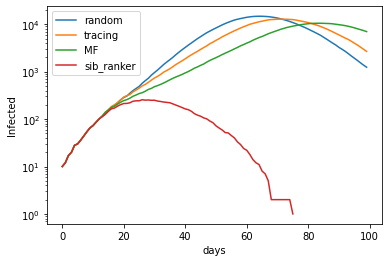

In [14]:
%matplotlib inline
to_plot = "I"
for s in ress.keys():
    plt.plot(ress[s][to_plot], label = s)
plt.semilogy()
plt.ylabel("Infected")
plt.xlabel("days")
plt.legend()
plt.show()